# Simulating an M/M/1 Queueing System with Python and SimPy

## Author: Fernando A. Acosta-Perez

### Overview
This notebook demonstrates the simulation of an M/M/1 queueing system using the SimPy library in Python. The simulation evaluates key metrics such as average waiting time and average queue size, providing insights into the system's performance under specific arrival and service rates.

---


## Import libraries

In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

## Build Simulation

In [3]:
class MonitoredResource(simpy.Resource):
    """
    Extends simpy.Resource to log queue lengths and timestamps at requests and releases.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []  # To store queue length and timestamp

    def request(self, *args, **kwargs):
        self.data.append((self._env.now, len(self.queue)))  # Log queue length at request
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        self.data.append((self._env.now, len(self.queue)))  # Log queue length at release
        return super().release(*args, **kwargs)


class MM1QueueSimulation:
    """
    Encapsulates the M/M/1 queue simulation using SimPy.
    """

    def __init__(self, simulation_time, interarrival_rate, service_rate, num_servers, verbose=True):
        """
        Initialize simulation parameters and setup.
        Args:
            simulation_time (float): Total time to run the simulation.
            interarrival_rate (float): Mean arrival rate (lambda).
            service_rate (float): Mean service rate (mu).
            num_servers (int): Number of servers in the system.
            verbose (bool): Whether to print simulation updates (default=True).
        """
        self.simulation_time = simulation_time
        self.interarrival_rate = interarrival_rate
        self.service_rate = service_rate
        self.num_servers = num_servers
        self.verbose = verbose

        # Create environment and monitored resource
        self.env = simpy.Environment()
        self.server = MonitoredResource(self.env, capacity=self.num_servers)

        # Lists to store metrics
        self.wait_times = []

    def log(self, message):
        """
        Prints a message if verbose mode is enabled.
        """
        if self.verbose:
            print(message)

    def customer_process(self, name, arrival_time):
        """
        Simulates a single customer’s journey through the system.
        Args:
            name (str): Customer identifier.
            arrival_time (float): Time of arrival.
        """
        self.log(f"{name} arrives at {self.env.now:.2f}")

        with self.server.request() as request:
            # Wait for server availability
            yield request

            # Calculate and log waiting time
            wait_time = self.env.now - arrival_time
            self.wait_times.append(wait_time)
            self.log(f"{name} starts service at {self.env.now:.2f} after waiting {wait_time:.2f}")

            # Simulate service time
            service_time = random.expovariate(self.service_rate)
            yield self.env.timeout(service_time)
            self.log(f"{name} leaves at {self.env.now:.2f}")

    def customer_arrivals(self):
        """
        Simulates the arrival of customers based on an exponential interarrival time.
        """
        customer_count = 0
        while True:
            # Time until the next customer arrives
            interarrival_time = random.expovariate(self.interarrival_rate)
            yield self.env.timeout(interarrival_time)

            # Create a new customer process
            customer_count += 1
            self.env.process(self.customer_process(f"Customer {customer_count}", self.env.now))

    def run(self):
        """
        Runs the simulation.
        """
        # Start the customer arrival process
        self.env.process(self.customer_arrivals())

        # Run the simulation
        self.env.run(until=self.simulation_time)

        # Log the final queue size
        final_queue_size = len(self.server.queue)
        self.server.data.append((self.simulation_time, final_queue_size))

    def compute_metrics(self):
        """
        Computes and displays key metrics from the simulation.
        """
        # Compute average waiting time
        avg_waiting_time = np.mean(self.wait_times) if self.wait_times else 0

        # Process resource data
        queue_data = np.array(self.server.data)
        event_times = queue_data[:, 0]
        queue_sizes = queue_data[:, 1]

        # Calculate time intervals
        time_intervals = np.diff(np.append(0, event_times))

        # Calculate time-weighted average queue size
        avg_queue_size = np.sum(queue_sizes * time_intervals) / self.simulation_time

        # Display metrics
        print(f"\nAverage waiting time (simulation): {avg_waiting_time:.2f} time units")
        print(f"Average queue size (simulation): {avg_queue_size:.2f}")

    def plot_queue(self):
        """
        Plots the queue size over time.
        """
        queue_data = np.array(self.server.data)
        env_time = queue_data[:, 0]
        queue_sizes = queue_data[:, 1]

        plt.figure()
        plt.step(env_time, queue_sizes, where='post')
        plt.xlabel('Environment Time')
        plt.ylabel('Queue Size')
        plt.title('Queue Size Over Time')
        plt.grid(True)
        plt.show()

    def plot_waiting_time_density(self):
        """
        Plots the density of waiting times using a kernel density estimate (KDE).
        """
        if not self.wait_times:
            print("No waiting times recorded; cannot plot density.")
            return

        # Compute kernel density estimate
        kde = gaussian_kde(self.wait_times)
        x_vals = np.linspace(min(self.wait_times), max(self.wait_times), 500)
        y_vals = kde(x_vals)

        # Plot density
        plt.figure()
        plt.plot(x_vals, y_vals, label="Waiting Time Density")
        plt.xlabel('Waiting Time')
        plt.ylabel('Density')
        plt.title('Density of Waiting Times')
        plt.grid(True)
        plt.legend()
        plt.show()

## Execution


Average waiting time (simulation): 4.46 time units
Average queue size (simulation): 4.46


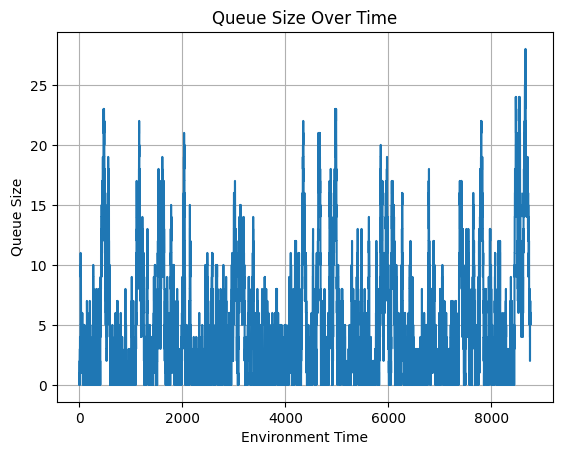

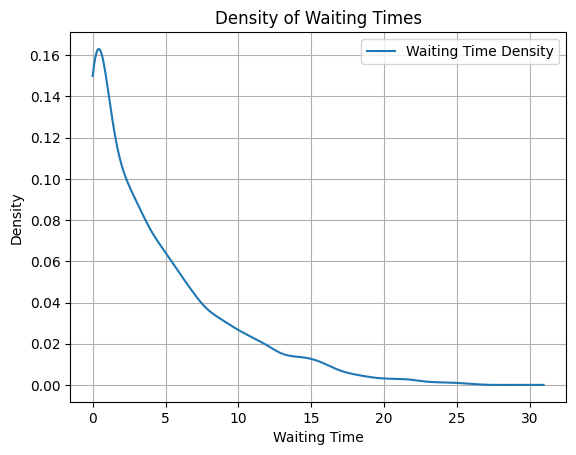

In [4]:
# Main Execution
if __name__ == "__main__":
    # Simulation parameters
    SIMULATION_TIME = 24 * 365  # Total time to simulate
    INTERARRIVAL_RATE = 1       # Mean arrival rate (customers per time unit)
    SERVICE_RATE = 1.2          # Mean service rate (customers served per time unit)
    NUM_SERVERS = 1             # Number of servers (M/M/1)

    # Create and run the simulation
    sim = MM1QueueSimulation(SIMULATION_TIME, INTERARRIVAL_RATE, SERVICE_RATE, NUM_SERVERS, verbose=False)
    sim.run()
    sim.compute_metrics()
    sim.plot_queue()
    sim.plot_waiting_time_density()


## Data Analysis

In [216]:
plt.style.use('seaborn-v0_8-pastel')

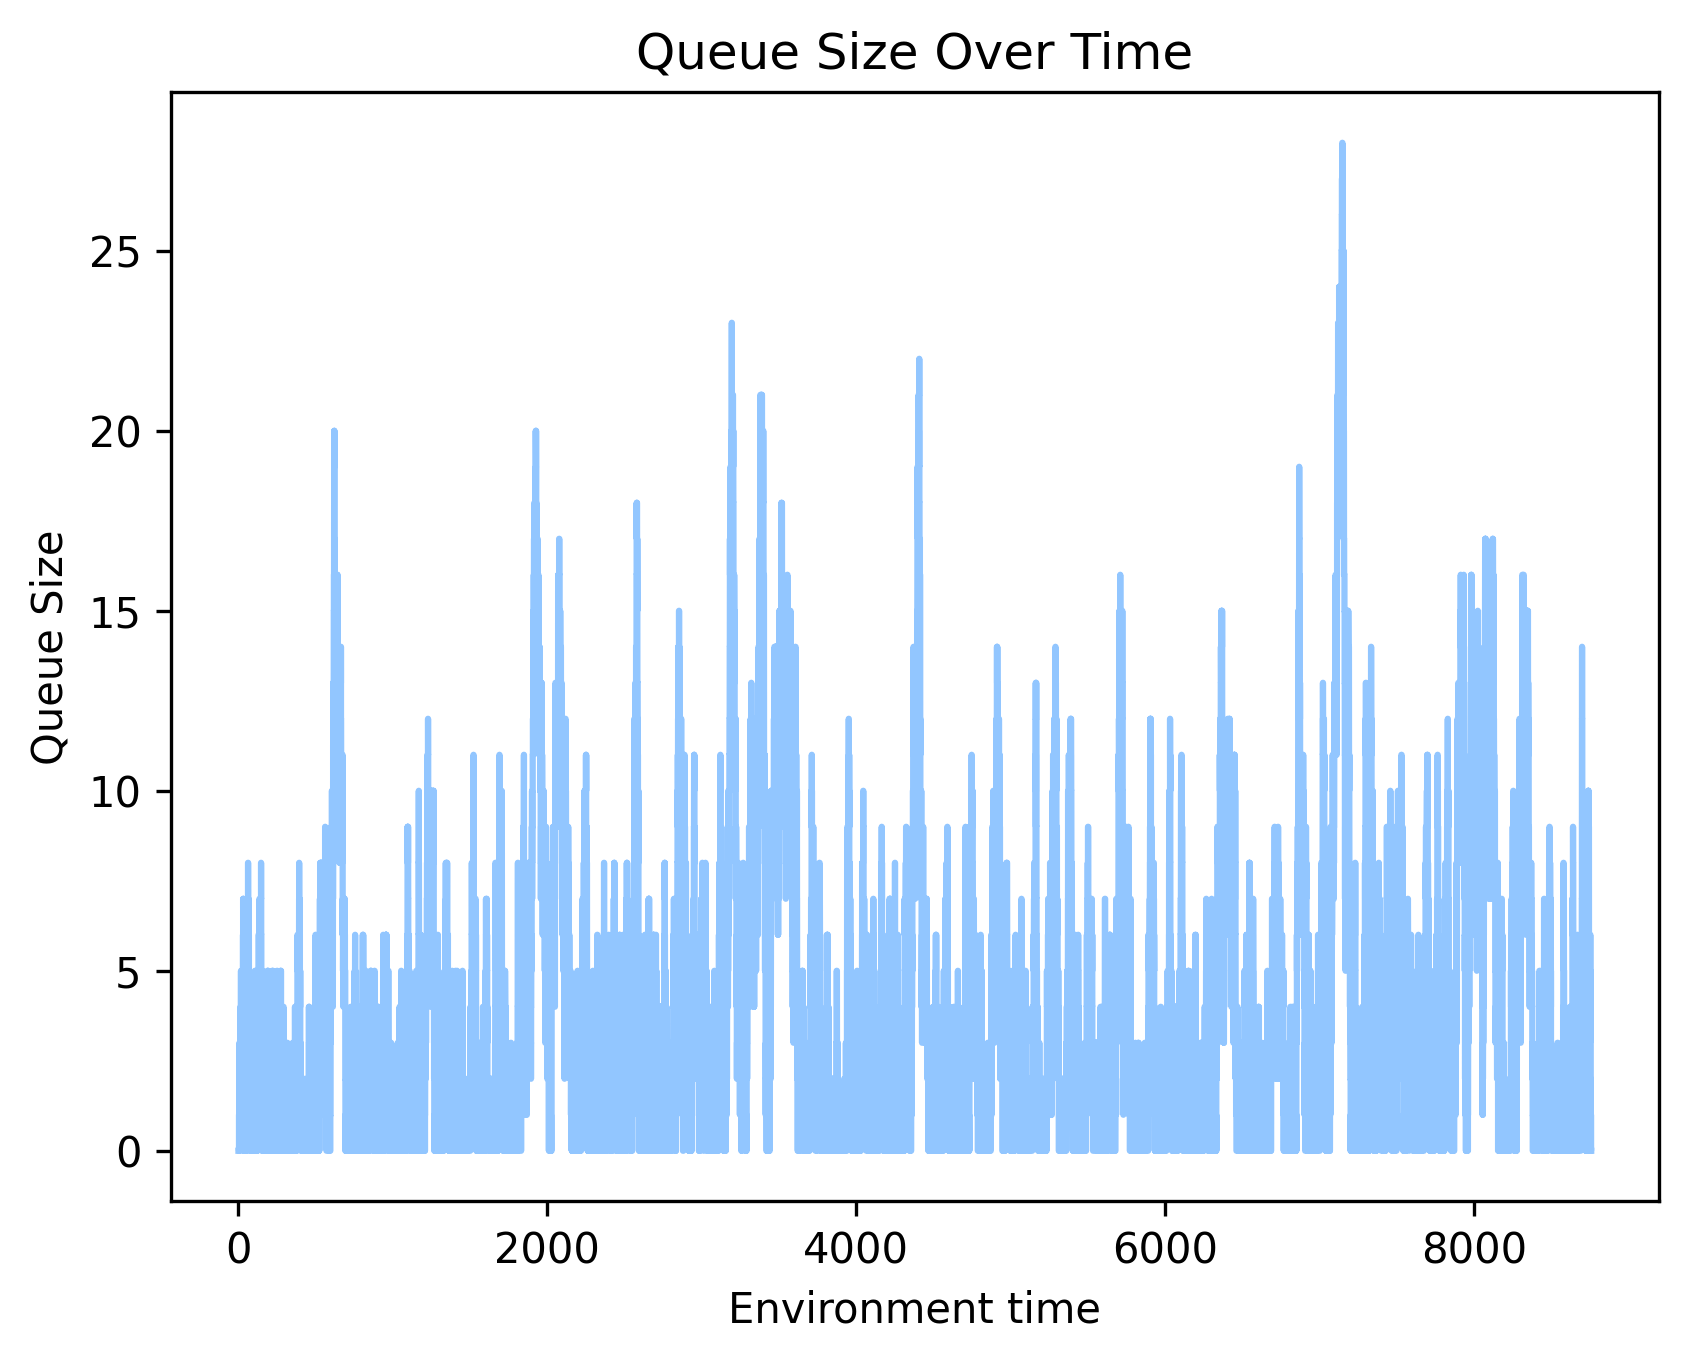

In [223]:
# Define data
data= np.array(queue_sizes)
env_time= data[:, 0]
queue= data[:, 1]

# Plot queue size as a step plot
plt.figure(dpi=300)
plt.step(env_time, queue, where='post')
plt.xlabel('Environment time')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Time')
plt.show()
plt.close()


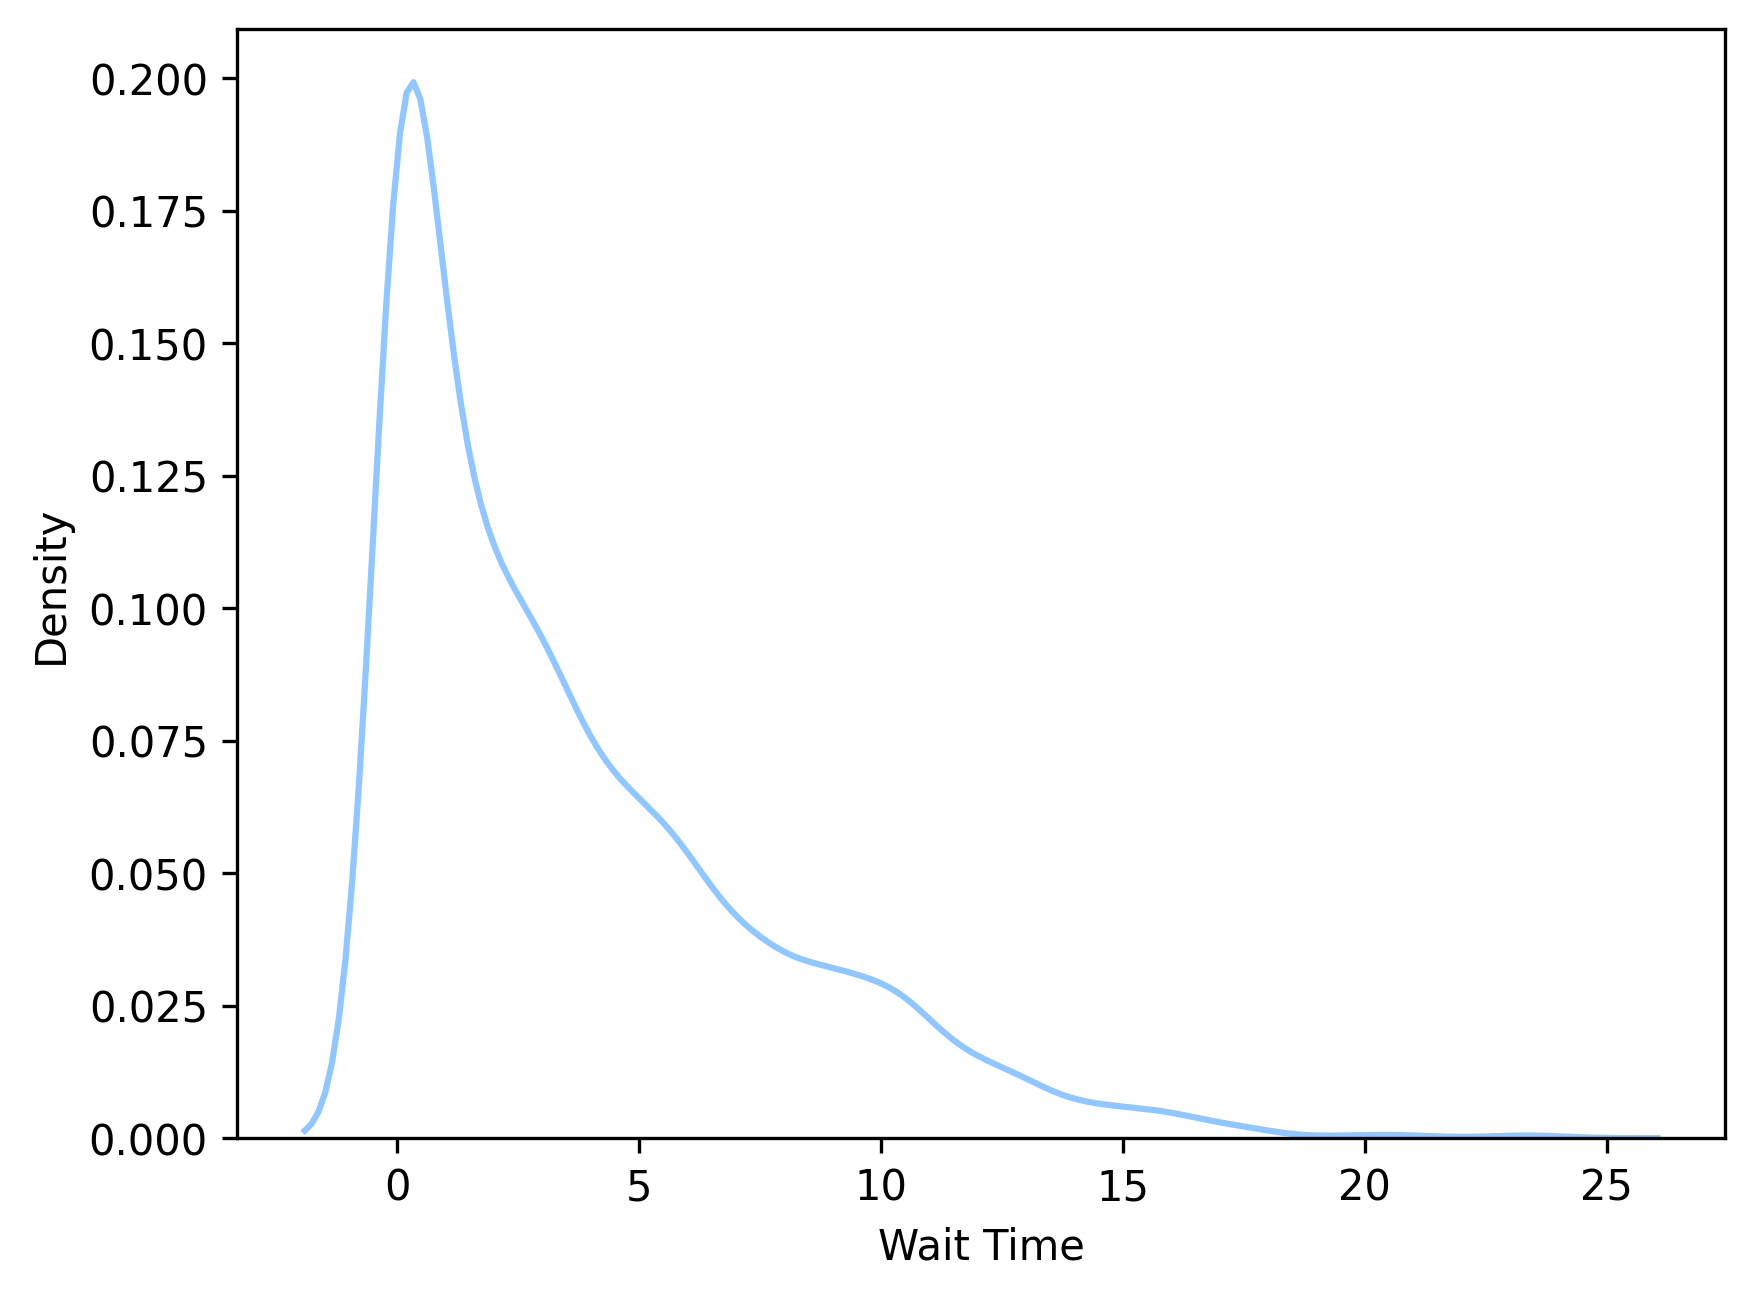

In [224]:
# Visualize waiting time
plt.figure(dpi=300)
sns.kdeplot(wait_times)
plt.xlabel('Wait Time')
plt.show()
plt.close()